In [1]:
# Importing  essential Data Analysis libraries
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error



import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Read the data from the Excel file
data = pd.read_excel('Data/CaseStudyData.xlsx')

In [3]:
#Read in the data from the CSV file
#data = pd.read_csv('Data/CaseStudyData.csv')

In [4]:
#get some generic statistics about data
print(f"1. Shape: {data.shape}")
print(f"2. Number of datapoints: {len(data)}", )
print(f"3. No of missing values: {data.isnull().sum().sum()}")
data.head(5)

1. Shape: (333405, 7)
2. Number of datapoints: 333405
3. No of missing values: 8


,DATE,ANONYMIZED CATEGORY,ANONYMIZED PRODUCT,ANONYMIZED BUSINESS,ANONYMIZED LOCATION,QUANTITY,UNIT PRICE
0,2024-08-18 21:32:00,Category-106,Product-21f4,Business-de42,Location-1ba8,1,850.0
1,2024-08-18 21:32:00,Category-120,Product-4156,Business-de42,Location-1ba8,2,1910.0
2,2024-08-18 21:32:00,Category-121,Product-49bd,Business-de42,Location-1ba8,1,3670.0
3,2024-08-18 21:32:00,Category-76,Product-61dd,Business-de42,Location-1ba8,1,2605.0
4,2024-08-18 21:32:00,Category-119,Product-66e0,Business-de42,Location-1ba8,5,1480.0


 **There are 8 missing values and dates aren't properly arranged. we need to either replace these missing values or drop them**
 
**Another issue is our date column values are not arranged in chronological order**

**For proper Exploratory Data Analysis and machine learning this is paramount**

In [6]:
#Get general information and understanding of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333405 entries, 0 to 333404
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   DATE                 333405 non-null  datetime64[ns]
 1   ANONYMIZED CATEGORY  333405 non-null  object        
 2   ANONYMIZED PRODUCT   333405 non-null  object        
 3   ANONYMIZED BUSINESS  333405 non-null  object        
 4   ANONYMIZED LOCATION  333405 non-null  object        
 5   QUANTITY             333405 non-null  int64         
 6   UNIT PRICE           333397 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 17.8+ MB


**I can see that the data types for each column are are ok**

# Section 1: Data Preprocessing/CLeaning #
   

**First things first, I prefer to create a copy of my data and also to change the capitalisation of my columns to small letters for convinience in typing.**

In [10]:
#create a copy of the original data
preprocdata_df = data.copy()

In [11]:
preprocdata_df.columns = [i.lower() for i in preprocdata_df.columns]
preprocdata_df.columns

Index(['date', 'anonymized category', 'anonymized product',
       'anonymized business', 'anonymized location', 'quantity', 'unit price'],
      dtype='object')

## 1.1 Arranging Data in Chronological Order ##

In [13]:
#Sorting rows by date
preprocdata_df = preprocdata_df.sort_values(by='date')

In [14]:
preprocdata_df.head(5)

,date,anonymized category,anonymized product,anonymized business,anonymized location,quantity,unit price
112231,2024-01-01 05:54:00,Category-75,Product-086d,Business-83dd,Location-66f4,10,2185.0
112232,2024-01-01 05:54:00,Category-85,Product-0c64,Business-83dd,Location-66f4,1,1190.0
179543,2024-01-01 07:18:00,Category-75,Product-2175,Business-d7a8,Location-1979,1,4365.0
179544,2024-01-01 07:18:00,Category-120,Product-4156,Business-d7a8,Location-1979,2,2180.0
101383,2024-01-01 10:45:00,Category-85,Product-6859,Business-4af0,Location-d1a8,2,885.0


## 1.2 Removing Missing values ##

In [16]:
#Removing NA Values
preprocdata_df.dropna(inplace=True)

In [17]:
preprocdata_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333397 entries, 112231 to 216096
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 333397 non-null  datetime64[ns]
 1   anonymized category  333397 non-null  object        
 2   anonymized product   333397 non-null  object        
 3   anonymized business  333397 non-null  object        
 4   anonymized location  333397 non-null  object        
 5   quantity             333397 non-null  int64         
 6   unit price           333397 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 20.3+ MB


**I have successfully removed the missing values the original rows were 333405 and now they are 333397 rows left**

## 1.3 Checking for Dublicates ##

In [20]:
#Check for duplicates
preprocdata_df[preprocdata_df.duplicated()]

,date,anonymized category,anonymized product,anonymized business,anonymized location,quantity,unit price
244229,2024-01-01 12:48:00,Category-91,Product-8ebc,Business-fef1,Location-3e32,1,1540.0
244230,2024-01-01 12:48:00,Category-111,Product-bdba,Business-fef1,Location-3e32,1,577.0
136824,2024-01-01 16:27:00,Category-76,Product-e805,Business-fba5,Location-1ba8,1,7580.0
136823,2024-01-01 16:27:00,Category-77,Product-d09c,Business-fba5,Location-1ba8,2,2980.0
136822,2024-01-01 16:27:00,Category-91,Product-1b48,Business-fba5,Location-1ba8,1,3680.0
...,...,...,...,...,...,...,...
46805,2024-12-27 20:22:00,Category-120,Product-1e80,Business-30b8,Location-3fc0,1,1780.0
46807,2024-12-27 20:22:00,Category-119,Product-e98d,Business-30b8,Location-3fc0,1,1680.0
300784,2024-12-27 20:22:00,Category-120,Product-7864,Business-30b8,Location-3fc0,1,1930.0
57900,2024-12-29 19:41:00,Category-120,Product-83fd,Business-3215,Location-689f,5,1660.0


In [21]:
print('No of duplicates in our CaseStudyData is: {}'.format(sum(preprocdata_df.duplicated())))

No of duplicates in our CaseStudyData is: 3524


**My suspicion that our data might have duplicates has proven to be true, our data has 3524 rows of duplicates.**
**The next step is getting rid of the duplicates.**

In [23]:
#Dropping duplicates
preprocdata_df.drop_duplicates(inplace=True)

In [24]:
#Check if there are still duplicate
print('There are {} duplicates left'.format(sum(preprocdata_df.duplicated())))

There are 0 duplicates left


In [25]:
print(f"New Shape After Dropping Duplicates: {preprocdata_df.shape}")

New Shape After Dropping Duplicates: (329873, 7)


**My CaseStudyData shape has now changed from Shape 333405 rows to 329873 rows**

## 1.4  Filtering out rows where 'unit price' is zero

### 1.4.1 Extracting rows 'Unit Price' == 0 and Saving to Our Data Folder

In [29]:
# Extracting rows where 'unit price' is zero
preprocdataWithZeroPrices_df = preprocdata_df[preprocdata_df['unit price'] == 0]

# Saving the zero_price_df for later analysis
preprocdataWithZeroPrices_df.to_csv('Data/zero_unit_prices.csv', index=False)

### 1.4.2 Masking  & Continuing analysis with non zero unit prices

In [31]:
# Filtering out rows where 'unit price' is zero
preprocdata_df = preprocdata_df[preprocdata_df['unit price'] != 0]

In [32]:
print(f"New Shape After deleting rows whose unit price ==0 : {preprocdata_df.shape}")

New Shape After deleting rows whose unit price ==0 : (329850, 7)


**Determining whether zero prices are suitable for analyses is important.** I woould consider it irrelevant or misleading if I get rid of them without analysising it. I would have kept them if; I was assessing the frequency of promotions, or analyzing the impact of free products on customer behavior.

## 1.5 Feature Engineering #

**Now is time to adjust or add some of the features of our dataset are all about**

### 1.5.1 Adding 'month-year' column

In [37]:
preprocdata_df['month-year'] = preprocdata_df['date'].dt.strftime('%B %Y')
preprocdata_df.head(5)

,date,anonymized category,anonymized product,anonymized business,anonymized location,quantity,unit price,month-year
112231,2024-01-01 05:54:00,Category-75,Product-086d,Business-83dd,Location-66f4,10,2185.0,January 2024
112232,2024-01-01 05:54:00,Category-85,Product-0c64,Business-83dd,Location-66f4,1,1190.0,January 2024
179543,2024-01-01 07:18:00,Category-75,Product-2175,Business-d7a8,Location-1979,1,4365.0,January 2024
179544,2024-01-01 07:18:00,Category-120,Product-4156,Business-d7a8,Location-1979,2,2180.0,January 2024
101383,2024-01-01 10:45:00,Category-85,Product-6859,Business-4af0,Location-d1a8,2,885.0,January 2024


### 1.5.2 Adding 'total_price' column

In [39]:
preprocdata_df['sales']=preprocdata_df['unit price'] * preprocdata_df['quantity']
preprocdata_df.head(5)

,date,anonymized category,anonymized product,anonymized business,anonymized location,quantity,unit price,month-year,sales
112231,2024-01-01 05:54:00,Category-75,Product-086d,Business-83dd,Location-66f4,10,2185.0,January 2024,21850.0
112232,2024-01-01 05:54:00,Category-85,Product-0c64,Business-83dd,Location-66f4,1,1190.0,January 2024,1190.0
179543,2024-01-01 07:18:00,Category-75,Product-2175,Business-d7a8,Location-1979,1,4365.0,January 2024,4365.0
179544,2024-01-01 07:18:00,Category-120,Product-4156,Business-d7a8,Location-1979,2,2180.0,January 2024,4360.0
101383,2024-01-01 10:45:00,Category-85,Product-6859,Business-4af0,Location-d1a8,2,885.0,January 2024,1770.0


In [40]:
(preprocdata_df['sales']).mean()

5362.965584356526

# Section 2: Exploratory Data Analysis(EDA)

## 2.1 Summary Statisitcs for Numerical Attributes

In [43]:
preprocdata_df.describe()

,date,quantity,unit price,sales
count,329850,329850.000000,329850.000000,3.298500e+05
mean,2024-07-18 11:58:19.945793792,2.321437,2319.178281,5.362966e+03
min,2024-01-01 05:54:00,0.000000,1.000000,0.000000e+00
25%,2024-04-30 16:39:00,1.000000,1420.000000,1.520000e+03
50%,2024-07-29 18:40:30,1.000000,1840.000000,2.740000e+03
75%,2024-10-14 21:33:00,2.000000,2750.000000,5.565000e+03
max,2024-12-31 18:24:00,359.000000,16136.000000,1.914000e+06
std,NaN,3.767623,1582.515392,1.094428e+04


**25% of the business have a sold quantity and a unit price of less than 1 (unit) and 1420.00 respectively, while 50% have sold lesser  quantities  and a unit price of 1 (unit) and  1840 respectively. Lastly, 75% of the business stores have sold a lower quantity and a unit price of 2 (units) and  2750 respectively**

**Average Sales is 5362**

**For the dates, our first data point is on 2024-01-01 05:54:00 and last data point is on 2024-12-31 18:24:00; implying our dataset is a year's sales data**


### 2.2.1 Ploting histograms to back up our statistics

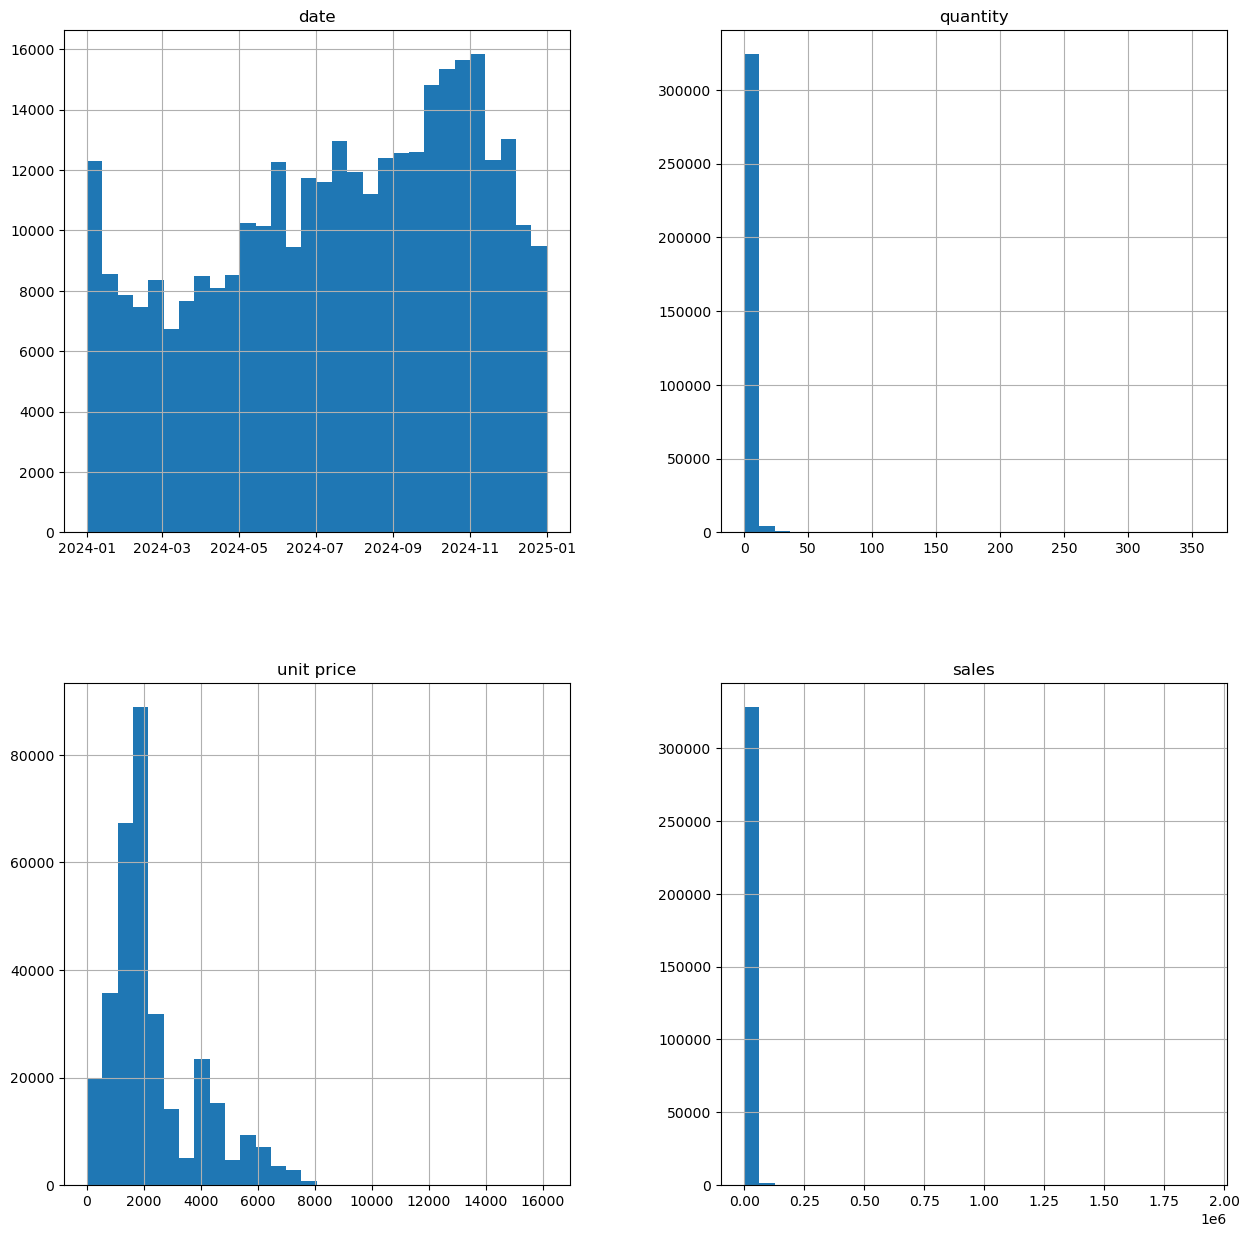

In [46]:
preprocdata_df.hist(bins=30, figsize=(15,15))

# Save the figure
plt.savefig('Images/Histograms for Numerical Attributes.png', format='png', dpi=300)

plt.show()

1. The date histogram gives the speculation that the  sales activities began at a high in Jan 2024 were then dropped consistently, it
     wasn't until April 2024 that the sales picked up and by the end of July 2024, the sales picked up steadily to November 2024. However, 
     sales activities dropped at the end of last month, December 2024

2. You can see that the unit price graph is skewed to the right; meaning many people bought items whose unit price was more than 2000

3. You can also see that slightly over 300,000 of the sales  were of quantities less than 15 items



## 2.2  Summary Statisitcs for our Categorical Attributes

**The categorical attributes are those columns whose data type is an object. They include; 'anonymized category', 'anonymized product', 'anonymized business' and 'anonymized location'**

In [50]:
categorical_col = [col for col in preprocdata_df.columns if preprocdata_df[col].dtype == 'object']
categorical_col

['anonymized category',
 'anonymized product',
 'anonymized business',
 'anonymized location',
 'month-year']

In [51]:
for value in categorical_col:
    print(f'Number of unique in {value} :',preprocdata_df[value].nunique())

Number of unique in anonymized category : 46
Number of unique in anonymized product : 807
Number of unique in anonymized business : 4799
Number of unique in anonymized location : 53
Number of unique in month-year : 12


This Sales data has 46 anonymized category, 807 anonymized product, 4799 anonymized business and 12 month-year(could mean months  data)

## 2.3 Sales Overview:

### 2.3.1 Plotting total quantities vs month-year


**Calculating total Quantity and Value grouped by:**

         1. Anonymized Category
         2. Anonymized Business
     

#### 2.3.1.1 Anonymized category by Quantity

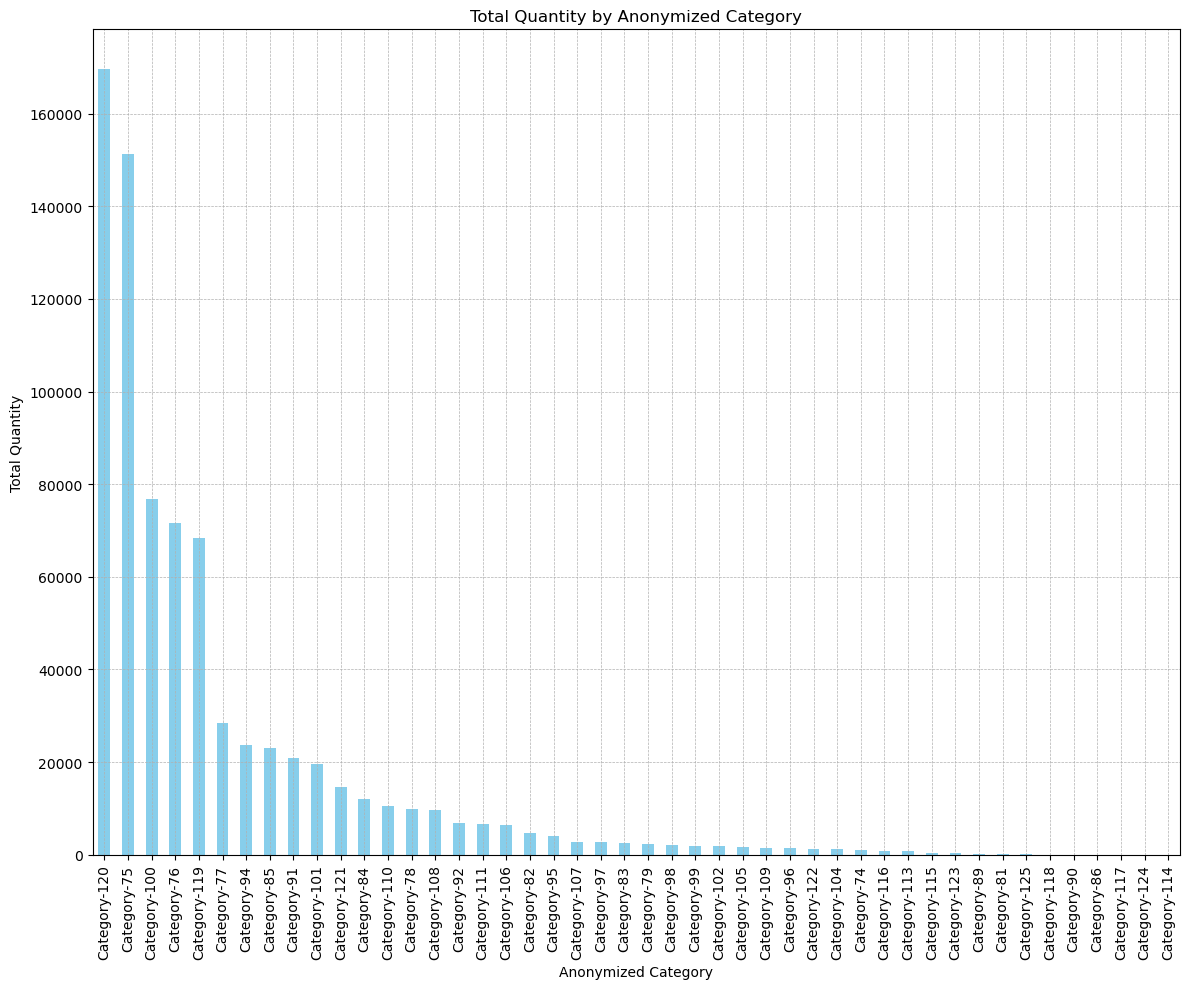

In [56]:
# Group by 'anonymized category' and  total quantity
anonycategories = preprocdata_df.groupby('anonymized category')['quantity'].sum().sort_values(ascending=False)

#Plot bar graph for Total Quantity vs 'anonymized category'

plt.figure(figsize=(12, 10))
anonycategories.plot(kind='bar', color='skyblue')
plt.title('Total Quantity by Anonymized Category')
plt.xlabel('Anonymized Category')
plt.ylabel('Total Quantity')
plt.xticks(rotation=90)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save the figure
plt.savefig('Images/Total Quantity by Anonymized Category.png',format='png', dpi=300)

plt.show()




This graph offers clear insights into the relative performance of different categories;

### 1. It Identifies Key Performers
    
**High Volume Leaders** Categories like Category-120 and Category-75, Category-76 and Category-119  are top performers with substantially higher quantities than others. This indicates that these categories are likely central to your business operations, popular among customers, or critical in your product line.

### 2. Spotting Underperformers
    
**Categories at the bottom of the plot (Low volume laggards)**, such as Category 114, Category-117 and Category-124, show very low quantities, which might indicate products that are not resonating with the market, are possibly outdated, or suffer from poor visibility or availability.

### 3. Market Concentration and Dispersion
**Market Concentration:** For quantities associated with categories like Category-120, Category-75, and Category-100 show high numbers an indication that these categories likely dominate their respective markets. The significant difference in quantities between these leading categories and others suggests **a concentrated market**, where a few categories capture a substantial portion of the market share.

**Market Dispersion** Conversely, at the lower end of the quantity spectrum such as Category 114, Category-117 and Category-124 could suggest a few things. 

--Niche Markets:-- These categories might represent niche markets with specific customer bases. While they don't contribute significantly to the overall quantities, they may serve strategic purposes.

--Market Testing:-- Low quantities could also indicate newer categories that are in the early stages of market introduction. 

### 4. Optimization of inventory and Supply Chain Management
    
**Stock Optimization:** For categories with high quantities, ensure that inventory levels are maintained to meet demand without overstocking, which can increase costs or lead to excess inventory.

**Supply Chain Adjustments:** For categories with increasing trends, consider strengthening supply chain mechanisms to ensure product availability.


#### 2.3.1.2 Plotting Top 50  Anonymized Businesses by Quantity

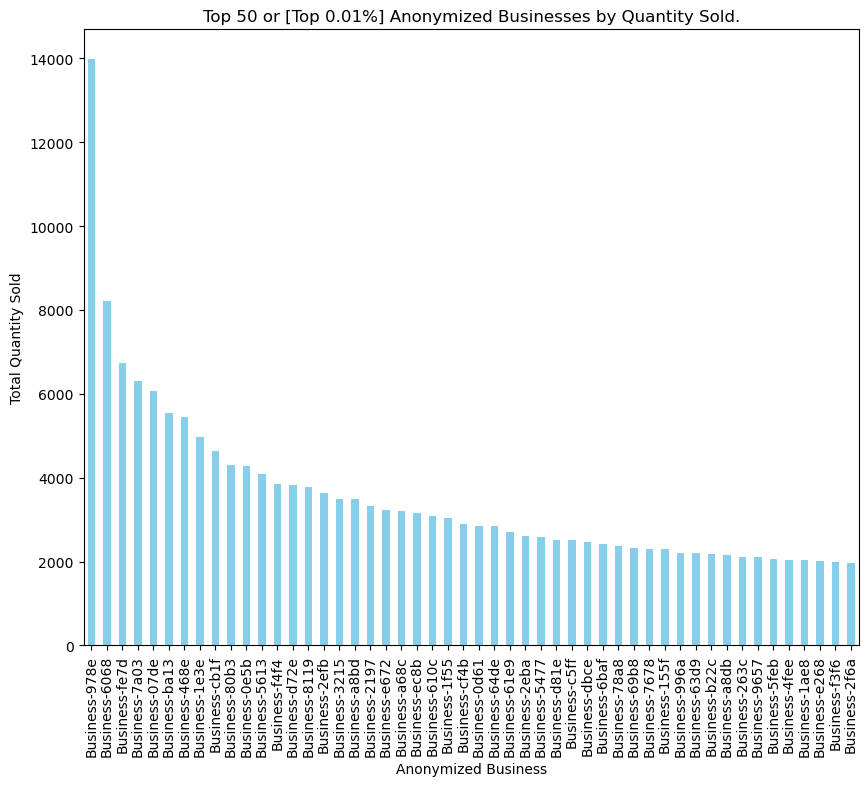

In [59]:
# Group by 'anonymized category' and  total quantity
anonybusinesses = preprocdata_df.groupby('anonymized business')['quantity'].sum().sort_values(ascending=False)

#Get Top 50 'Anonymized business' by Quantity sold
top_50_businesses = anonybusinesses.head(50)
top_50_businesses.plot(kind='bar', figsize=(10, 8), color='skyblue')
plt.title('Top 50 or [Top 0.01%] Anonymized Businesses by Quantity Sold.')
plt.xlabel('Anonymized Business')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=90)

# Save the figure
plt.savefig('Images/Top 50 [0.01%] Anonymized Businesses by Quantity Sold.png',format='png', dpi=300)

plt.show()


#### 2.3.1.3 Plotting Bottom 100 Anonymized business

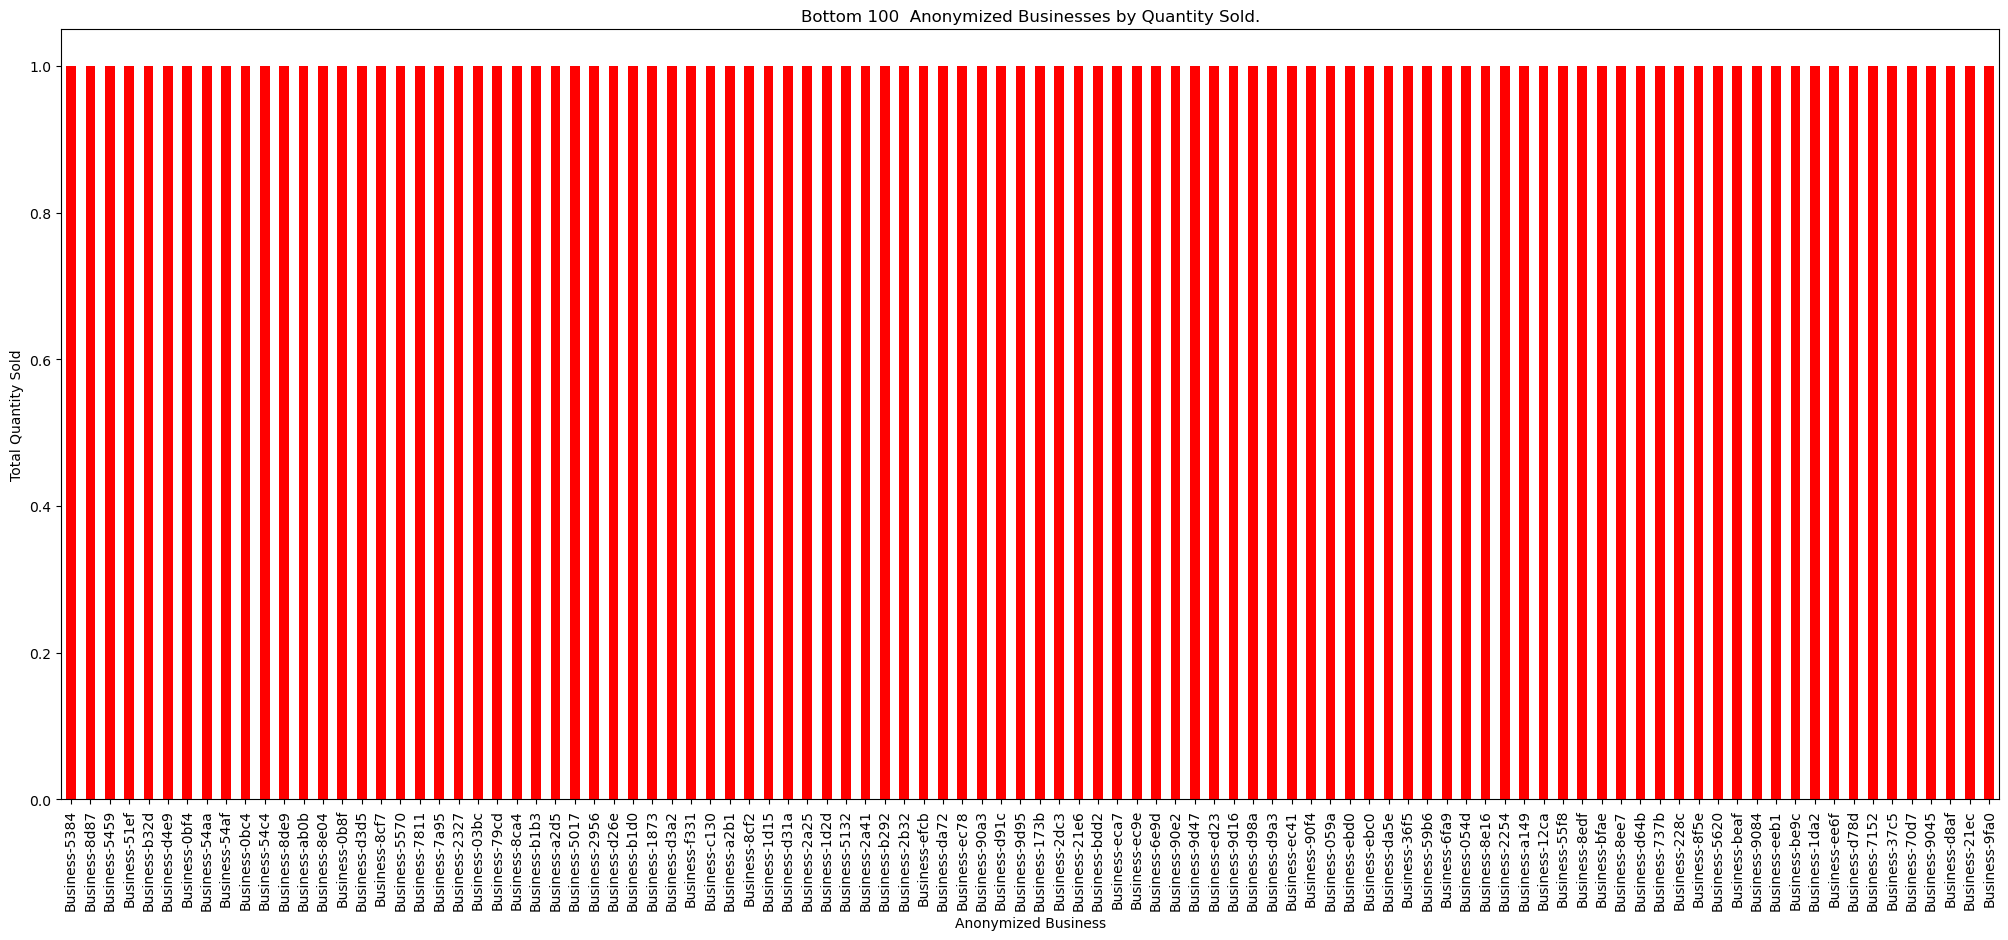

In [61]:
# Group by 'anonymized category' and  total quantity
anonybusinesses = preprocdata_df.groupby('anonymized business')['quantity'].sum().sort_values(ascending=False)

#Get Top 50 'Anonymized business' by Quantity sold
bottom_100_businesses = anonybusinesses.tail(100)
bottom_100_businesses.plot(kind='bar', figsize=(25, 10), color='r')
plt.title('Bottom 100  Anonymized Businesses by Quantity Sold.')
plt.xlabel('Anonymized Business')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=90)

# Save the figure
plt.savefig('Images/Bottom 100 Anonymized Businesses by Quantity Sold.png',format='png', dpi=300)

plt.show()


Plotting the bottom 100 companies reveals shocking news!!! All the 100 Anonymized companies have only sold 1 quantity. 

**Probably there might be an issue with either the data or the sales distribution among those companies. It could suggest that these bottom 100 companies are either very small, have limited sales through the channel being analyzed, or there might be some error in data collection or processing**

      ____________________________## A Thorough Investigation into this is required##_______________________________


However, one thing is clear regarding this categorical column when we build our model. We might  have to delete it due to the high cardinality or create a Mitigation strategy such as re-adjusting our categories

### 2.3.2 Sales Trends Over Time Serires Analysis

#### 2.3.2.1 Plotting total quantity vs month-year

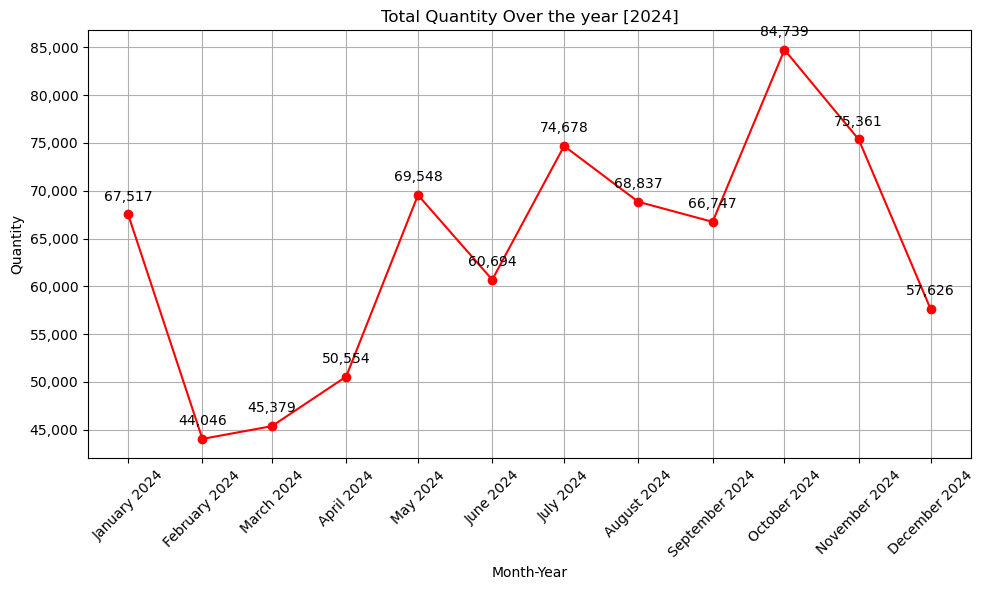

In [65]:
# Group by 'month-year' and sum the sales
monthly_quantities = preprocdata_df.groupby('month-year')['quantity'].sum().reset_index()

df=pd.DataFrame(monthly_quantities)

# Convert 'Month-Year' to datetime
df['month-year date'] = pd.to_datetime(df['month-year'].apply(lambda x: '1 ' + x))

# Sort DataFrame by the new 'Month-Year Date' column
df_sorted = df.sort_values('month-year date')

# Plotting Total Sales vs month
plt.figure(figsize=(10, 6))
plt.plot(df_sorted['month-year date'], df_sorted['quantity'], marker='o', linestyle='-', color='r')
plt.title('Total Quantity Over the year [2024]')
plt.xlabel('Month-Year')
plt.ylabel('Quantity')
plt.grid(True)

# Format y-axis with large number formatting
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Annotate each point with its value
for i, txt in enumerate(df_sorted['quantity']):
    plt.annotate(f'{txt:,.0f}', (df_sorted['month-year date'].iloc[i], df_sorted['quantity'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')


# Set x-ticks to the sorted date, but label them with the original 'Month-Year' strings
plt.xticks(df_sorted['month-year date'], df_sorted['month-year'], rotation=45)
plt.tight_layout()

# Save the figure
plt.savefig('Images/Total Quantity Over the year [2024].png', format='png', dpi=300)


plt.show()

The above plot **shows the variations in quantity across different months, yielding several insights;**

  ***1. Seasonal Variability***
The data demonstrates significant fluctuations which may suggest seasonal impacts on quantity. For instance:

**High Peaks:** Notable peaks in July, November, and October could be linked to specific seasonal events or consumer buying patterns. 
    October shows the highest quantity, which might be due to preparations for holiday seasons, promotions, or end-of-season sales.

**Low Points:** February shows the lowest quantity, which could be attributed to post-holiday slumps or typically lower consumer
    spending following the New Year.

***2. Growth Trends***
**Ascending Trend Towards Year-End:** Starting from mid-year, there is a general upward trend peaking in October. This could indicate a buildup in activities or increasing demand leading into the later part of the year, perhaps due to marketing strategies or seasonal consumer behaviour.

***3. Business Implications***

**i. Strategic Planning:** The business might consider these trends for planning inventory, marketing campaigns, and resource allocation. For example, ramping up production or marketing efforts in anticipation of peak months or designing promotions to boost sales during typically low months.

**ii. Resource Allocation:** Understanding low and high periods can help in managing resources more effectively, such as adjusting workforce levels, distribution logistics, and budgeting.

***4. Potential External Influences***

**Market Events:** Promotions, holidays, or external market events could significantly impact these figures. For example, back-to-school promotions could boost the quantities in August, while holiday sales might explain the high numbers in October and November.

**Economic Factors:** Economic conditions such as consumer confidence, inflation rates, and employment levels could also influence these variations. A downturn in the economy might reflect in reduced quantities as seen in the early part of the year.




#### 2.3.2.2 Plotting total sales vs month-year

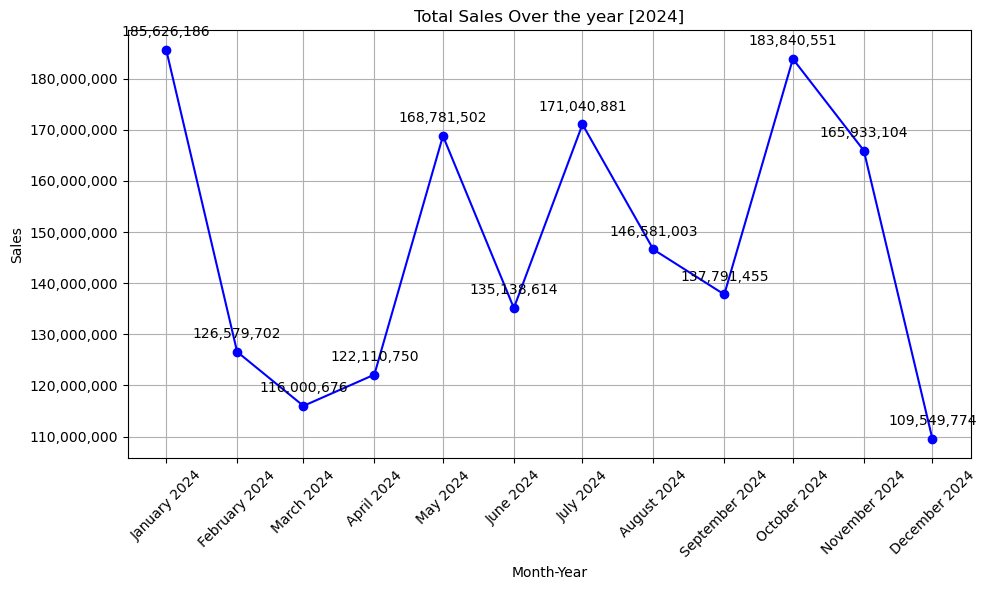

In [68]:
# Group by 'month-year' and sum the sales
monthly_sales = preprocdata_df.groupby('month-year')['sales'].sum().reset_index()

df=pd.DataFrame(monthly_sales)

# Convert 'Month-Year' to datetime
df['month-year date'] = pd.to_datetime(df['month-year'].apply(lambda x: '1 ' + x))

# Sort DataFrame by the new 'Month-Year Date' column
df_sorted = df.sort_values('month-year date')

# Plotting Total Sales vs month
plt.figure(figsize=(10, 6))
plt.plot(df_sorted['month-year date'], df_sorted['sales'], marker='o', linestyle='-', color='b')
plt.title('Total Sales Over the year [2024]')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.grid(True)

# Format y-axis with large number formatting
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Annotate each point with its value
for i, txt in enumerate(df_sorted['sales']):
    plt.annotate(f'{txt:,.0f}', (df_sorted['month-year date'].iloc[i], df_sorted['sales'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')


# Set x-ticks to the sorted date, but label them with the original 'Month-Year' strings
plt.xticks(df_sorted['month-year date'], df_sorted['month-year'], rotation=45)
plt.tight_layout()

# Save the figure
plt.savefig('Images/Total Sales Over the year [2024].png', format='png', dpi=300)

plt.show()

The **Total Sales vs Time graph mirrors our earlier graph of Total Quantity vs Time**, whereby we expect high sales to happen during the start of the and lower sales to happen during December 2024.

Peak Sales month were observed in **January 2024**, with a total of approximately **185.6 million**. **Another peak** occurs in **October 2024**, close to **183.8 million**. **This could indicate strong sales activities typically at the start and near the end of the year, possibly influenced by new year spending and holiday season preparations respectively.**

The **lowest sales point** occurs in **December 2024**, at about **109.5 million**, which **might seem counterintuitive given the holiday season**. This dip **could suggest inventory shortages, market saturation, or other external economic factors impacting consumer spending.**

**Mid-Year Sales** show **considerable variability but remain relatively high from May through August**, averaging around **155 million.** This period may benefit from mid-year marketing campaigns, seasonal offers, or vacation spending.

**The general trend for the sales** appears to be **cyclical with significant peaks around January and October and notable dips in February, March, and particularly December.**



## 2.4 Performance Analysis

### 2.4.1 Identifying the top 5 most frequently purchased products (based on Quantity).

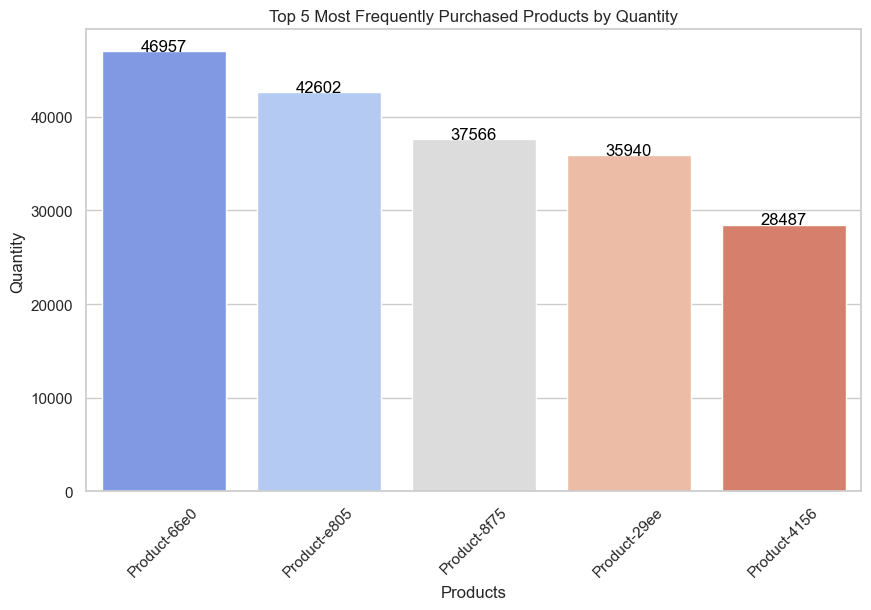

In [72]:
products = preprocdata_df.groupby('anonymized product')['quantity'].sum().sort_values(ascending=False)

#Get Top 5 'Anonymized Production' by Quantity Sold
top_5_products = products.head(5)

df=pd.DataFrame(top_5_products)

# Setting the color palette
sns.set_theme(style="whitegrid")

# Creating the bar chart
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='anonymized product', y='quantity', data=df, palette='coolwarm')

# Adding the text annotations
for index, row in df.iterrows():
    bar_plot.text(row.name, row.quantity, round(row.quantity, 2), color='black', ha="center")
    
bar_plot.set_title('Top 5 Most Frequently Purchased Products by Quantity')
plt.xlabel('Products')
plt.ylabel('Quantity')
plt.xticks(rotation=45)

# Save the figure
plt.savefig('Images/Top 5 most Frequently purchased products  by Quantity Sold.png',format='png', dpi=300)

plt.show()




Delving deeper into the statistics for these high-performing products can provide a more nuanced analysis;

    1. Sales Distribution and Leadership
**Product-66e0 is the bestseller**, indicating either a strong market fit or effective sales strategies. It might have the best visibility, pricing, or consumer preference in its category.Sales figures gradually decrease from Product-66e0 to Product-4156. However, **Product-4156's sales are still impressive**, suggesting it is a strong contender within its niche.

    2. Market Dynamics
The close sales numbers between some products, like Product-e805 and Product-8f75, suggest competitive dynamics where slight variations in consumer preferences or seasonal impacts could shift rankings.

    3. Customer Insights:
Wouldn't it be great to know why these products are doing well? A better place to start this poignant matter having detailed customer feedback and reviews for these top products. This can offer insights into why they perform well. This can include aspects like product quality, customer service experiences, and user satisfaction.

Secondly, segmenting the customer base and understanding demographic factors can help refine marketing strategies and possibly identify new opportunities within different customer groups.




### 2.4.2 Identify the top 5 most valuable products (based on Value).

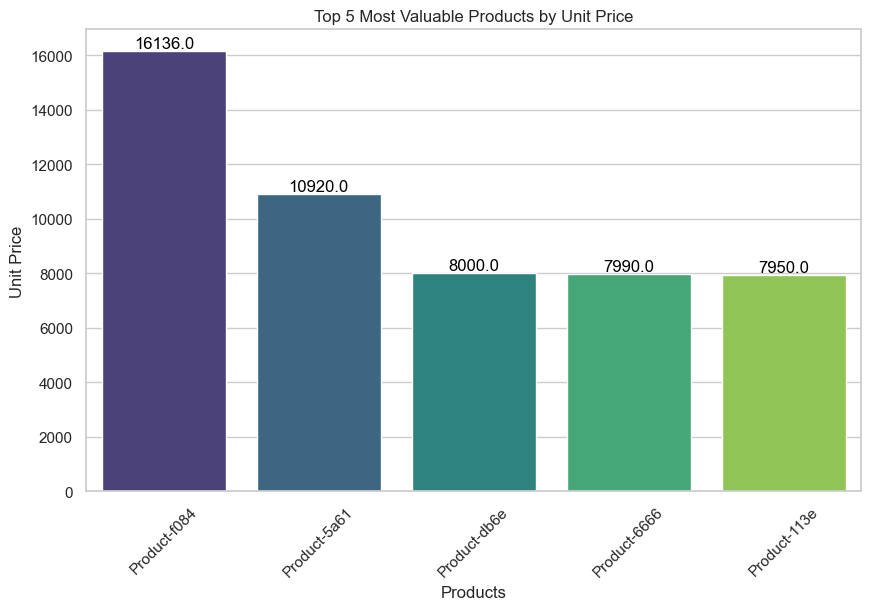

In [75]:
#Group by 'anonymized product', get the maximum 'unit price' and sort in descending order
val_products = preprocdata_df.groupby('anonymized product')['unit price'].max().sort_values(ascending=False)

#Get Top 5 'Anonymized Production' by Quantity Sold
top_5_valproducts = val_products.head(5)

val_df=pd.DataFrame(top_5_valproducts)
 
#Setting the color palette
sns.set_theme(style="whitegrid")

# Creating the bar chart
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='anonymized product',y='unit price', data=val_df, palette='viridis')

# Adding the text annotations for unit prices
for index, row in val_df.iterrows():
    bar_plot.text(index, row['unit price'], f'{row["unit price"]}', color='black', ha="center", va='bottom')

bar_plot.set_title('Top 5 Most Valuable Products by Unit Price')
plt.xlabel('Products')
plt.ylabel('Unit Price')
plt.xticks(rotation=45)

# Save the figure
plt.savefig('Images/Top 5 most Valuable products  by Unit Price.png',format='png', dpi=300)

plt.show()


### 2.4.3 Identify the bottom 15 less valuable products (based on Value).

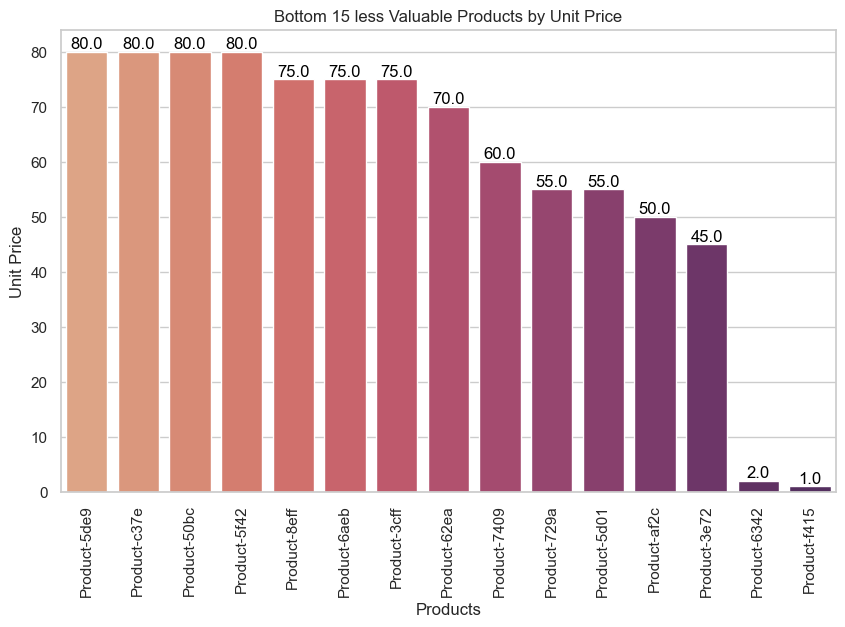

In [77]:
#Group by 'anonymized product', get the maximum 'unit price' and sort in descending order
val_products = preprocdata_df.groupby('anonymized product')['unit price'].max().sort_values(ascending=False)

#Get Top 5 'Anonymized Production' by Quantity Sold
bottom5_valproducts = val_products.tail(15)

val_df=pd.DataFrame(bottom5_valproducts)
 
#Setting the color palette
sns.set_theme(style="whitegrid")

# Creating the bar chart
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='anonymized product',y='unit price', data=val_df, palette='flare')

# Adding the text annotations for unit prices
for index, row in val_df.iterrows():
    bar_plot.text(index, row['unit price'], f'{row["unit price"]}', color='black', ha="center", va='bottom')

bar_plot.set_title('Bottom 15 less Valuable Products by Unit Price')
plt.xlabel('Products')
plt.ylabel('Unit Price')
plt.xticks(rotation=90)

# Save the figure
plt.savefig('Images/Bottom  15 most Less Valuable products  by Unit Price.png',format='png', dpi=300)

plt.show()

**This confirms that masking out the rows whose 'unit price' == 0 was the right move. However, it will be a good thing to ask Stakeholders why we have such products in the dataset**

# Section 3: Advanced Analysis

## 3.1 Segmentation analysis of businesses (Anonymized Business) based on their purchasing behavior   

In [81]:
## Extract year, month, day, and hour from the 'date' column
preprocdata_df['year'] = preprocdata_df['date'].dt.year
preprocdata_df['month'] = preprocdata_df['date'].dt.month
preprocdata_df['day'] = preprocdata_df['date'].dt.day
preprocdata_df['hour'] = preprocdata_df['date'].dt.hour

# 1. Calculate the Total Quantity purchased based on each business
total_quantity = preprocdata_df.groupby('anonymized business')['quantity'].sum()

# 2. Calculate the total value contributed by each business
total_value = preprocdata_df.groupby('anonymized business')['sales'].sum()

# 3. Calculate the frequency of transactions by each business
transaction_frequency = preprocdata_df.groupby('anonymized business')['date'].count()

# 4. # Calculate most common purchase hour
most_common_hour = preprocdata_df.groupby('anonymized business')['hour'].agg(lambda x: x.mode()[0])

# Combine all metrics into a single DataFrame
business_metrics = pd.DataFrame(
    {
    'Total Quantity Purchased': total_quantity,
    'Total Value Contributed': total_value,
    'Frequency of Transactions': transaction_frequency,
    'Most Common Purchase Hour': most_common_hour
    }
    )

### 3.1.1 Perform Segmentation

In [83]:
# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(business_metrics)

# Use K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(scaled_data)
business_metrics['Cluster'] = kmeans.labels_

In [84]:
# Classify businesses based on 'Total Value Contributed'
business_metrics['Value Category'] = pd.qcut(business_metrics['Total Value Contributed'], 3, labels=["Low Value", "Medium Value", "High Value"])

# Analyzing each value category
category_analysis = business_metrics.groupby('Value Category').agg({
    'Total Quantity Purchased': 'mean',
    'Total Value Contributed': 'mean',
    'Frequency of Transactions': 'mean',
    'Most Common Purchase Hour': lambda x: x.mode()[0]
})
print(category_analysis)

                Total Quantity Purchased  Total Value Contributed  \
Value Category                                                      
Low Value                       3.797500             6.279332e+03   
Medium Value                   26.166354             5.103634e+04   
High Value                    448.631250             1.048325e+06   

                Frequency of Transactions  Most Common Purchase Hour  
Value Category                                                        
Low Value                        2.978750                         19  
Medium Value                    17.437148                         19  
High Value                     185.751250                         19  


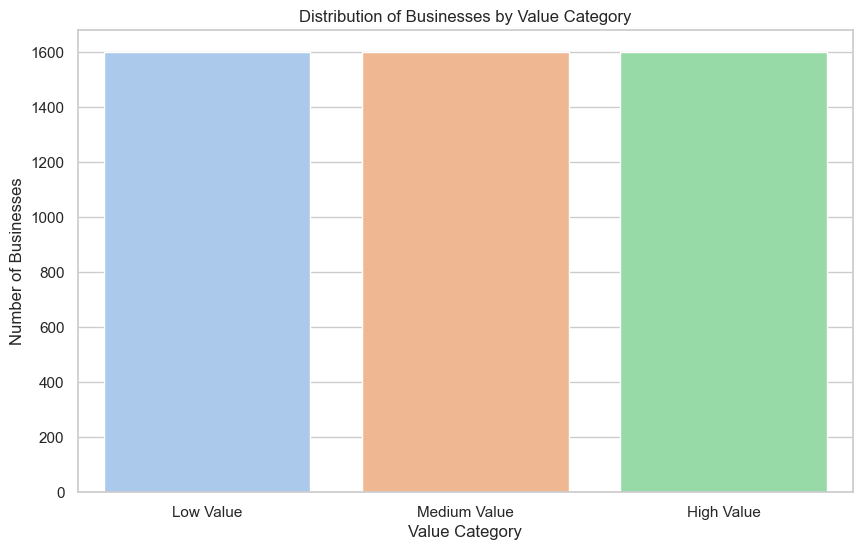

In [85]:
# Plotting value categories
plt.figure(figsize=(10, 6))
sns.countplot(x='Value Category', data=business_metrics, palette='pastel')
plt.title('Distribution of Businesses by Value Category')
plt.xlabel('Value Category')
plt.ylabel('Number of Businesses')

# Save the figure
plt.savefig('Images/Distribution of Businesses by Value Category.png',format='png', dpi=300)

plt.show()

**It is also important to know the disparity in the distribution of the businesses. From the above plot, we see that the distribution of the Anonymized Businesses is the same across all value categories with each  having about 1600 Businesses.**

**This could imply that the Stakeholders are indifferent over their preference for a particular value category.**

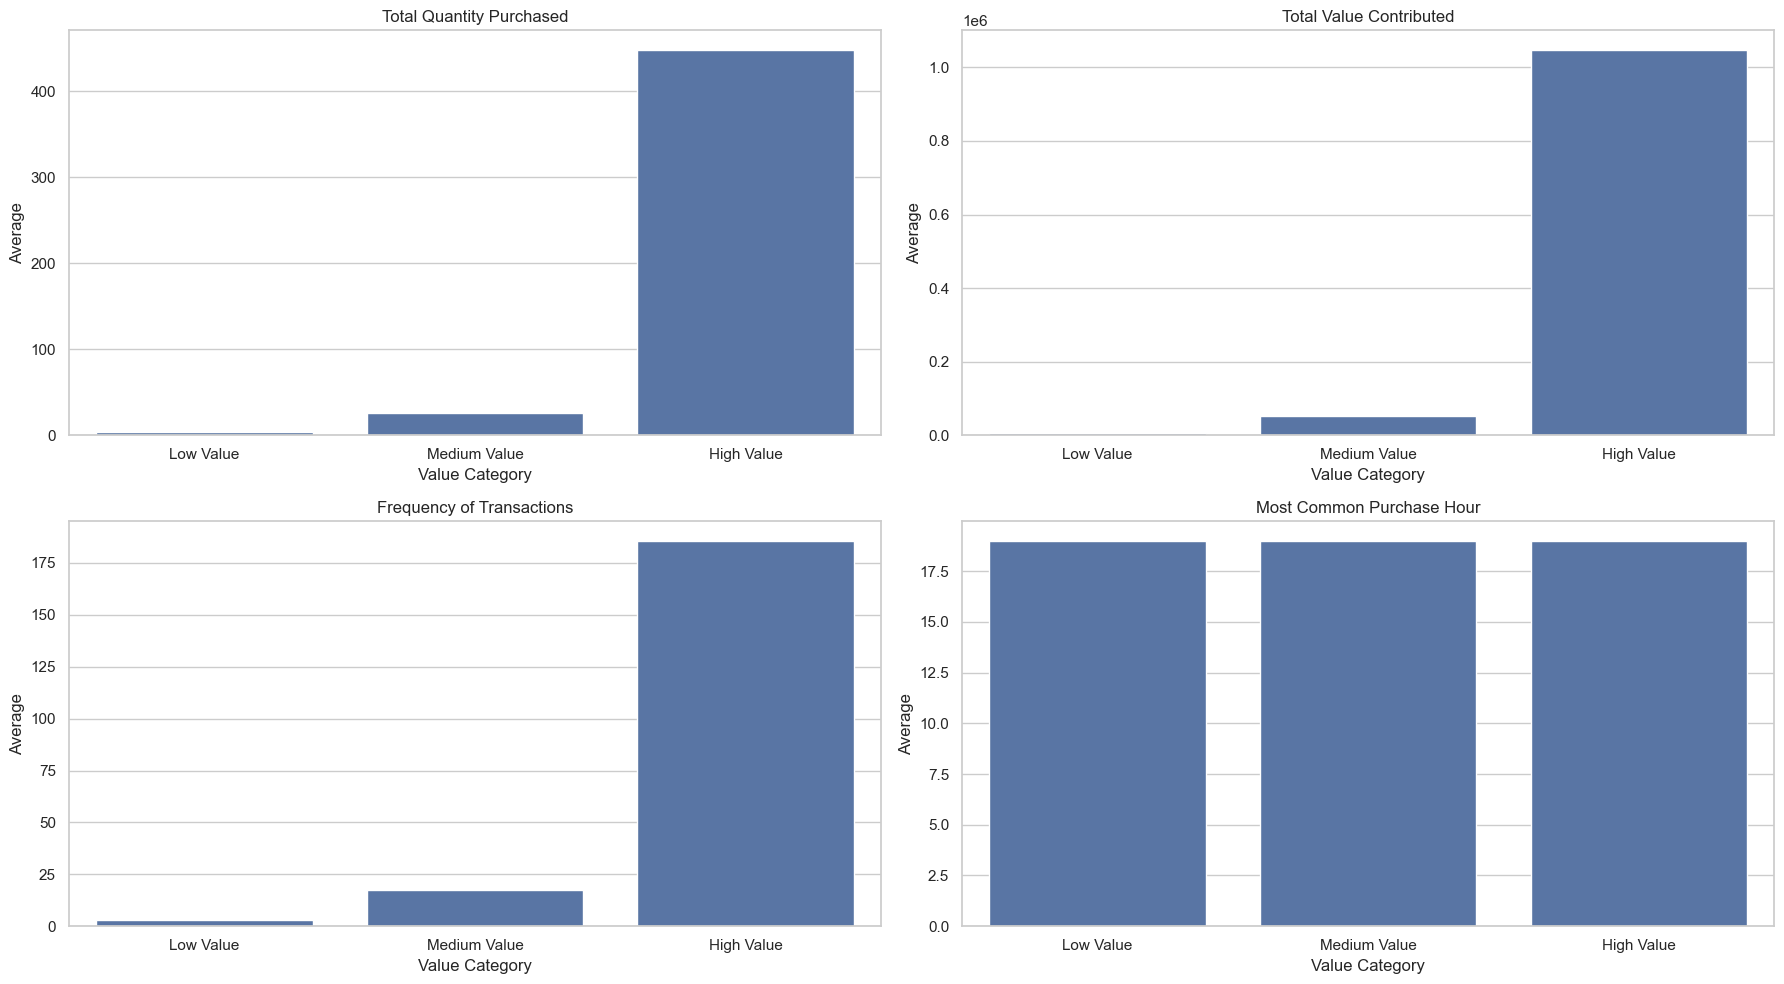

In [87]:
#ploting category analysis
df = pd.DataFrame(category_analysis)

# Set up the matplotlib figure
plt.figure(figsize=(18, 10))

# Titles
titles = ['Total Quantity Purchased', 'Total Value Contributed', 'Frequency of Transactions', 'Most Common Purchase Hour']

# Create a bar plot for each category
for i, feature in enumerate(titles, 1):
    plt.subplot(2, 2, i)
    sns.barplot(x='Value Category', y=feature, data=df)
    plt.title(feature)
    plt.ylabel('Average')
    plt.xlabel('Value Category')

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('Images/Plotting the Analyses of each value category.png',format='png', dpi=300)


# Show plot
plt.show()


## Comparative Analysis Across Three Business Value Categories: Low Value, Medium Value, and High Value

Below is a detailed breakdown of what each plot signifies and the potential implications:

### 1. Total Quantity Purchased
This plot reveals a stark contrast in the purchasing volumes among the three groups:


**Low-value customers purchase minimal quantities, averaging around 3.8 units.**

**Medium-value customers exhibit a moderate increase, averaging about 26.2 units.**

**High-value customers display significantly higher purchasing behaviour, averaging around 448.6 units.**

**Implications:** The exponential increase in quantity purchased from Low to High-Value customers suggests that High-Value customers could be bulk buyers or large-scale consumers. This group likely includes key accounts that might benefit from volume-based pricing strategies or bulk purchase incentives to maintain or increase their buying behaviour.

### 2. Total Value Contributed
This plot correlates strongly with the quantities purchased, reflecting the financial impact of each group:

**Low-value customers contribute an average of approximately 6,279.**

**Medium-value customers contribute significantly more, with an average close to 51,036.**

**High-value customers contribute a substantial average value of over 1 million.**

**Implications:** The direct relationship between the quantity purchased and the total value contributed emphasizes the importance of High-value customers to overall revenue. Tailoring specialized services, personalized pricing plans, and dedicated support for these customers could enhance loyalty and encourage sustained or increased spending.

### 3. Frequency of Transactions
This metric provides insight into how often customers engage in transactions:

**Low-value customers engage in transactions infrequently, with an average of about 3 transactions.**

**Medium-value customers are more active, participating in an average of 17 transactions.**

**High-value customers are the most frequent buyers, averaging 186 transactions.**

**Implications:** High transaction frequencies in the High-Value group suggest a steady relationship with the business, possibly due to contractual obligations, recurring needs, or high satisfaction. For medium-value customers, increasing engagement through loyalty programs or regular promotions might convert them into more frequent buyers. Low-value customers might require more aggressive acquisition and retention strategies to increase their transaction frequency.

### 4. Most Common Purchase Hour
An amazing find is that all groups predominantly make their purchases around the same hour of the day, 19:00 (7 PM). This uniformity across all categories suggests a peak operating hour for business transactions.

**Implications:** The 7 PM peak hour could indicate after-hours shopping behaviour or the closure of business day transactions. This time could be strategically targeted for flash sales, after-hours promotions, or special events to capture maximum customer attention and drive sales across all segments.

## Recommendations For Engagement
My focus will be on strategies that leverage customer segments' specific purchasing behaviours and common purchase hour of 19:00 (7 PM).

### 1. Low-Value Customers

**Targeted Promotions:** Introduce targeted promotions during the most common purchase hour (7 PM). This could include limited-time offers or small discounts to stimulate additional purchases and increase their total value contribution.

**Engagement Boosts:** Boost engagement with these customers through regular communication that highlights low-cost, high-value products. Emails or push notifications about deals around 7 PM could help in capturing their interest.

**Customer Loyalty Initiatives:** Start a basic loyalty program offering rewards for repeated purchases, which could help increase their frequency of transactions. Simple rewards like points per purchase that can be redeemed for discounts might be very effective.

### 2. Medium-Value Customers

**Personalized Marketing:** Use data from their purchase patterns to create personalized marketing messages that resonate with their needs. Offering product recommendations based on their past purchases can be sent out as targeted emails or displayed as ads at 7 PM.

**Customer Development:** Encourage these customers to move to high-value segments through up-sell and cross-sell strategies. For instance, offering a bundle that includes a slightly higher-priced item than they usually purchase at a value price.

**Enhanced Customer Experience:** Improve their shopping experience by ensuring that customer service is proactive around their most active hours, optimizing touchpoints for efficiency and satisfaction.

### 3. High-Value Customers

**Exclusive Access:** Provide these top-tier customers with exclusive access to new products or services before they are available to the general public. This can create a feeling of exclusivity and privilege.

**VIP Treatment:** Develop a VIP customer experience that includes personalized services, such as dedicated sales representatives available at their peak activity hours, especially around 7 PM when they are most likely to engage.

**Strategic Partnerships:** Offer them opportunities to provide input on future products or services. This can be facilitated through exclusive insight groups or advisory boards that meet during their common purchase hour, integrating their feedback directly into the business model.


## Conclusion
1. I can consider viewing trends by integrating the 'month-year' information in my  analysis for seasonal effects.
   
2. I can also, perform A/B testing on different marketing strategies tailored to each segment to validate the effectiveness of my segmentation.



## 3.2 Forecasting: Predicting the total sales (Value) for the next 3 months.  

In [91]:
# Set date column to index
preprocdata_df.set_index('date', inplace=True)

# Aggregate sales data monthly if needed
monthly_sales = preprocdata_df.resample('M').sum()['sales']

In [92]:
# Check the stationarity of our data to determine which model we may or may not use
result = adfuller(monthly_sales)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.678129
p-value: 0.077900


First, we check if the time series is stationary using  the Augmented Dickey-Fuller test, as many models assume stationarity.

The ADF static is ADF Statisti:  -2.678129 is negative, which is a good sign towards stationarity. However, the p-value: 0.077900 is greater than 0.05. Therefore, we fail to reject the null hypothesis, implying that there is not enough evidence to conclude that the series is stationary i.e it may have a unit root.

I will therefore use models that support nonstationarity. I will use SARIMA and Exponential Smoothing which are good for data that shows trends or seasonal patterns and then compare to see which model generalises well

### 3.2.1 Predicting the total sales using SARIMA

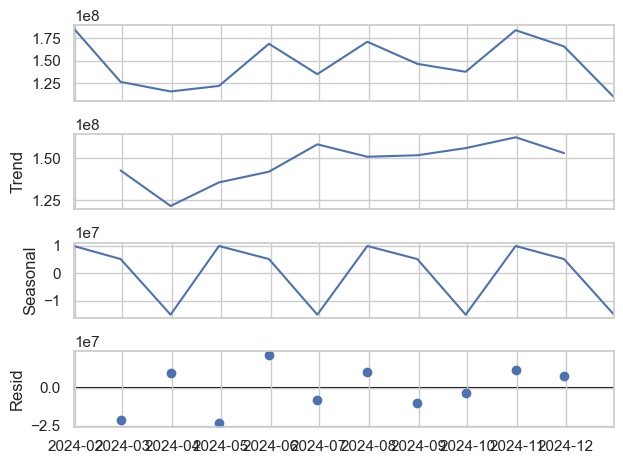

In [95]:
# Use seasonal decomposition to identify and confirm any seasonal patterns in the data.
mon_df= pd.DataFrame(monthly_sales)
result = seasonal_decompose(mon_df, model='additive',period=3) # Using a shorter cycle
result.plot()

# Save the figure
plt.savefig('Images/Seasonal Decomposition.png',format='png', dpi=300)

plt.show()


### 1.Trend Component:

There is  a mix of increasing and decreasing trend over the 3-month seasonal period.
The trend rises after the 3rd month up until the end of the year. However, there are periods of plateau or decline which might need further strategic review.

### 2. Seasonal Component:

Given the 3-month period, there are regular peaks and troughs corresponding with specific months each quarter that consistently show higher or lower sales. Like sales decrease at the end of each quarter, this could be due to quarterly financial cycles impacting purchasing behaviour negatively.

### 3. Residual Component:

The residuals indicate that most of the systematic information (trend and seasonality) has been captured by the model.

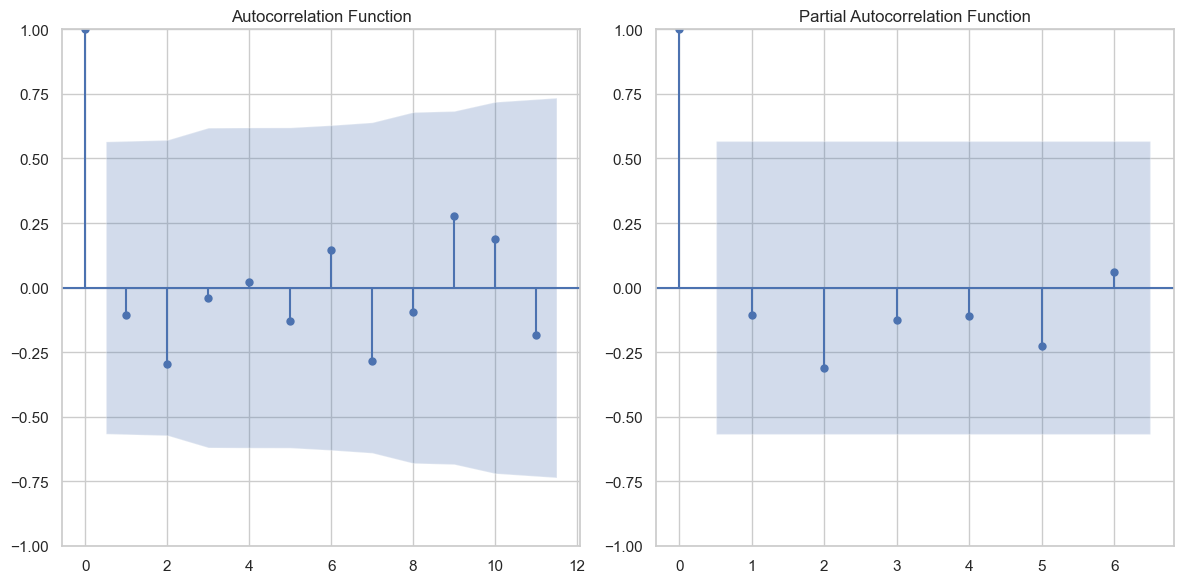

<Figure size 640x480 with 0 Axes>

In [97]:
# Plotting ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(mon_df['sales'], ax=plt.gca(), lags=11) 
plt.title('Autocorrelation Function')

plt.subplot(122)
plot_pacf(mon_df['sales'], ax=plt.gca(), lags=6, method='ywm') 
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

# Save the figure
plt.savefig('Images/ACF and PACF.png',format='png', dpi=300)

plt.show()

In [98]:
# Initial parameter guesses based on ACF and PACF
model = SARIMAX(mon_df['sales'],
                order=(1, 1, 1),  # Non-seasonal parameters
                seasonal_order=(1, 1, 1, 12))  # Seasonal parameters (assuming noticeable seasonality)
results = model.fit()

# Check the summary
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                   12
Model:      

 This problem is unconstrained.


### 3.2.1.1 Forecast the next 3 months using SARIMA

In [100]:
# Forecast the next 3 months
forecast = results.get_forecast(steps=3)
forecast_df = forecast.conf_int()
forecast_df['forecast'] = forecast.predicted_mean

# Displaying the forecast results
print(forecast_df)

             lower sales   upper sales      forecast
2025-01-31  2.023615e+08  2.023643e+08  2.023629e+08
2025-02-28  1.433150e+08  1.433178e+08  1.433164e+08
2025-03-31  1.327360e+08  1.327388e+08  1.327374e+08


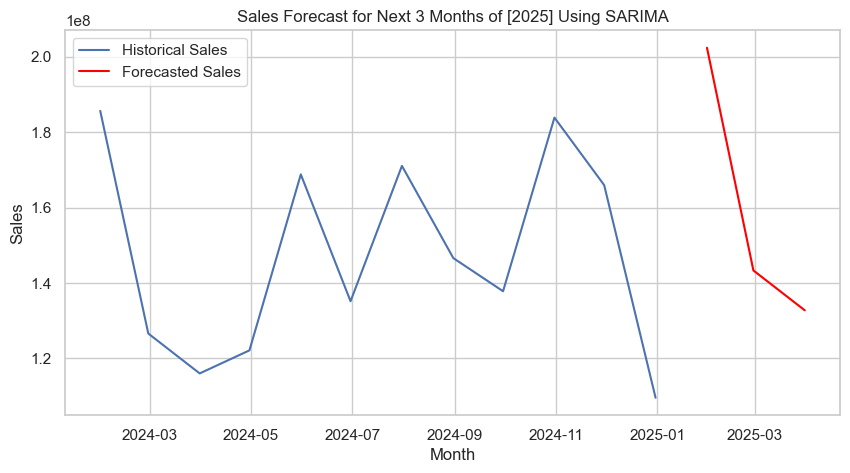

In [101]:
# Plot the forecast alongside the historical data
plt.figure(figsize=(10, 5))
plt.plot(mon_df.index, mon_df['sales'], label='Historical Sales')
plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecasted Sales', color='red')
plt.fill_between(forecast_df.index, forecast_df['lower sales'], forecast_df['upper sales'], color='pink', alpha=0.3)
plt.title('Sales Forecast for Next 3 Months of [2025] Using SARIMA')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig('Images/Sales Forecast for Next 3 Months of [2025] Using SARIMA .png',format='png', dpi=300)
plt.show()

### 3.2.2 Predicting the total sales using Exponential Smoothing

In [103]:
# Fit a Holt-Winters model
model = ExponentialSmoothing(mon_df['sales'], trend='add', seasonal='add', seasonal_periods=3)
model_fit = model.fit()

# Forecast the next 3 months
forecast = model_fit.forecast(steps=3)
print(forecast)

2025-01-31    1.801137e+08
2025-02-28    1.784127e+08
2025-03-31    1.612398e+08
Freq: ME, dtype: float64


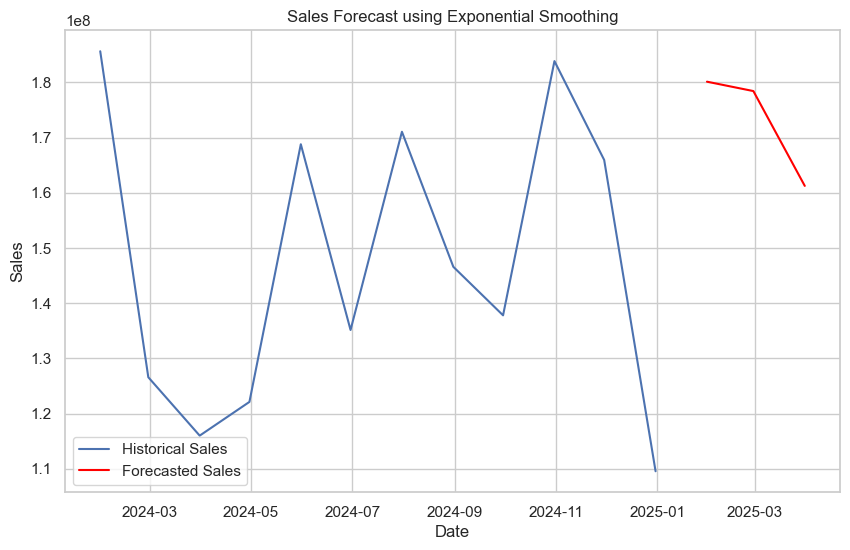

<Figure size 640x480 with 0 Axes>

In [104]:
pd.DataFrame(forecast)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(mon_df.index, mon_df['sales'], label='Historical Sales')
plt.plot(forecast.index, forecast, label='Forecasted Sales', color='red')
plt.title('Sales Forecast using Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Save the figure
plt.savefig('Images/Sales Forecast using Exponential Smoothing .png',format='png', dpi=300)

plt.show()

My Exponential Smoothing Curve is also ok. **But by observing the plots, I might choose to go with SARIMA over Exponential Smoothing.However this is just a speculation, I must compare both models using statistical methods like Mean Squared Error to see which model generalises better.**

### 3.2.3 evaluate accuracy of two models using Mean Squared Error (MSE)

In [107]:
# Split data into train and test
train = mon_df.iloc[:-3]   # first 9 months as training data
test = mon_df.iloc[-3:]   # last 3 months as test data

In [108]:
# Fit SARIMA Model
sarima_model = SARIMAX(train['sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fitted = sarima_model.fit(disp=False)

# Forecast
sarima_forecast = sarima_fitted.forecast(steps=len(test))

In [109]:
# Fit model ExponentialSmoothing
exp_model = ExponentialSmoothing(train['sales'], trend='add', seasonal='add', seasonal_periods=4)
exp_fitted = exp_model.fit()

# Forecast
exp_forecast = exp_fitted.forecast(steps=len(test))

In [110]:
# Calculate RMSE
exp_rmse = np.sqrt(mean_squared_error(test['sales'], exp_forecast))
sarima_rmse = np.sqrt(mean_squared_error(test['sales'], sarima_forecast))

print(f'Exponential Smoothing RMSE: {exp_rmse}')
print(f'SARIMA RMSE: {sarima_rmse}')

Exponential Smoothing RMSE: 38518381.456466876
SARIMA RMSE: 35166575.97095182


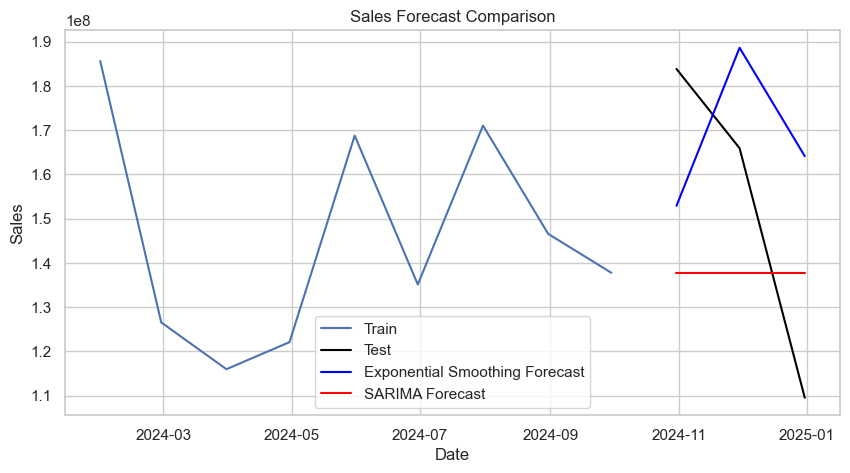

In [111]:
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['sales'], label='Train')
plt.plot(test.index, test['sales'], label='Test', color='black')
plt.plot(test.index, exp_forecast, label='Exponential Smoothing Forecast', color='blue')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='red')
plt.title('Sales Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

# Save the figure
plt.savefig('Images/Sales Forecast Comparison Between SARIMA & Exponential Smoothing.png',format='png', dpi=300)

plt.show()

RMSE is a measure of the differences between values predicted by a model and the values observed from the environment that is being modelled. 

The lower the RMSE, the better the model's performance is in terms of accuracy because it indicates a smaller difference between predicted and actual values.

**For our case, the SARIMA model has a lower RMSE compared to the Exponential Smoothing model. This suggests that the SARIMA model was better at generalizing our dataset and predicting future values more accurately within the test period.**


## 3.3 Anomaly Detection: Identify any unusual spikes/drops in sales performance (Quantity or Value)

In [114]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = mon_df['sales'].quantile(0.25)
Q3 = mon_df['sales'].quantile(0.75)
IQR = Q3 - Q1

# Define thresholds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers_iqr = mon_df[(mon_df['sales'] < lower_bound) | (mon_df['sales'] > upper_bound)]
print(outliers_iqr)

Empty DataFrame
Columns: [sales]
Index: []


Two methods are used to detect anomalies; the Z-score and the Interquartile Range (IQR).  I will be using the IQR method which is more robust than the Z-score method.

**"Empty DataFrame" means that no anomalies were detected based on the IQR criteria on our dataset.This implies;**

**Data Consistency:** The sales data does not contain any values that deviate significantly from the overall distribution pattern. This consistency could indicate stable sales performance over 2024 period. 

## 3.4 Correlation Analysis:Examine relationships between Quantity and Value.

In [117]:
qval_df = preprocdata_df[['quantity', 'sales']]

# Calculate correlation
correlation = qval_df['quantity'].corr(qval_df['sales'])
print("Correlation between Quantity and Sales: ", correlation)

Correlation between Quantity and Sales:  0.835389784227311


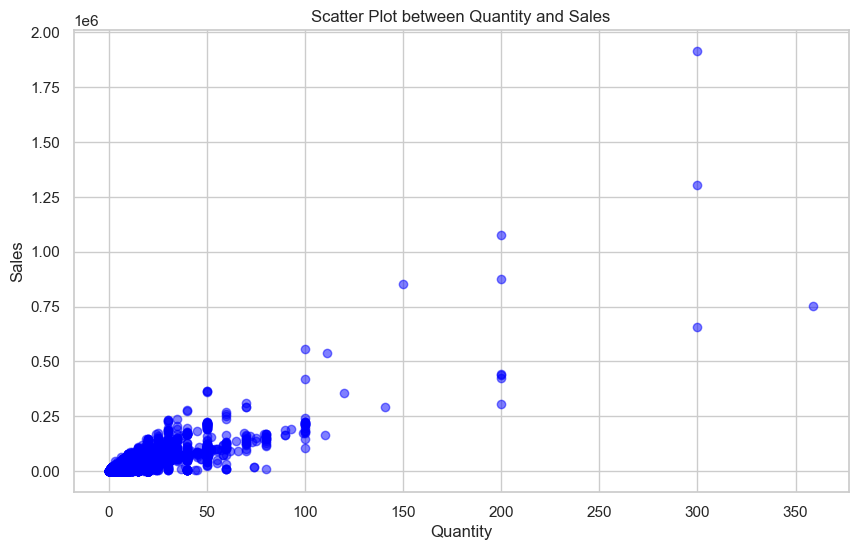

In [118]:
# plot scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(qval_df['quantity'], qval_df['sales'], color='blue', alpha=0.5)
plt.title('Scatter Plot between Quantity and Sales')
plt.xlabel('Quantity')
plt.ylabel('Sales')
plt.grid(True)

# Save the figure
plt.savefig('Images/Scatter Plot between Quantity and Sales.png',format='png', dpi=300)
plt.show()

### A correlation coefficient of 0.835389784227311 between quantity and sales indicates a strong positive linear relationship.

### 1. Interpretation 
This suggests that as the quantity of units sold increases, the sales also tend to increase. This is a strong indicator that higher sales volumes are associated with higher total sales.

### 2. The Business Insights for a higher correlation:

A strong correlation means that strategies aimed at increasing the quantity sold are likely effective in boosting overall revenue. This might be due to scale efficiencies, higher market penetration, or successful marketing campaigns.

# Section 4: Strategic Insights and Recommendations (20 points)

## 4.1 Product Strategy:analyzing sales data to find the product with the highest growth. 

In [122]:
# Group by month and product category, summing sales
monthly_sales = preprocdata_df.groupby(['month', 'anonymized category'])['sales'].sum().reset_index()

# Calculating monthly growth for each category
monthly_sales['previous_month_sales'] = monthly_sales.groupby('anonymized category')['sales'].shift(1)
monthly_sales['growth'] = (monthly_sales['sales'] - monthly_sales['previous_month_sales']) / monthly_sales['previous_month_sales']

# Identifying the product category with the highest average monthly growth
best_product = monthly_sales.groupby('anonymized category')['growth'].mean().idxmax()
print(f"Product to prioritize for marketing campaigns: {best_product}")


Product to prioritize for marketing campaigns: Category-98


### Therefore the product I will prioritize for the upcoming marketing campaigns is Category-98.Because of:

**1. Growth Potential:** A category with rapidly increasing sales suggests high market demand and customer interest, making it a prime candidate for focused marketing efforts to maximize revenue.

**Implementation:**
Launch targeted marketing campaigns using digital and traditional media to increase visibility.
Utilize promotions and discounts strategically to boost demand further, especially during peak buying seasons.

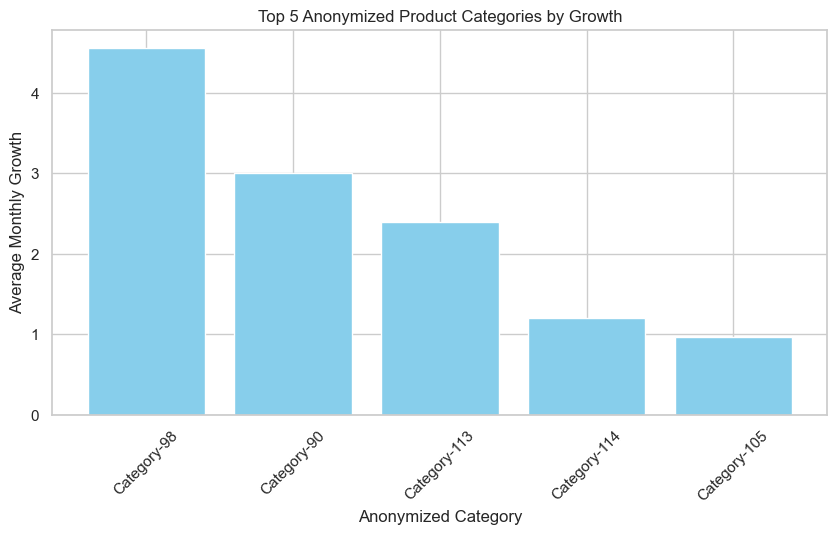

In [124]:
category_growth = monthly_sales.groupby('anonymized category')['growth'].mean().reset_index()
# Sort and take top 5
top_categories = category_growth.sort_values(by='growth', ascending=False).head(5)

# Plot top 5 product categories
plt.figure(figsize=(10, 5))
plt.bar(top_categories['anonymized category'], top_categories['growth'], color='skyblue')
plt.xlabel('Anonymized Category')
plt.ylabel('Average Monthly Growth')
plt.title('Top 5 Anonymized Product Categories by Growth')
plt.xticks(rotation=45)

# Save the figure
plt.savefig('Images/Top 5 Anonymized Product Categories by Growth.png',format='png', dpi=300)

plt.show()

## 4.2 Customer Retention: Identifying businesses that have reduced their purchase frequency over time.

In [126]:
# Calculate purchase frequency by business and month
purchase_frequency = preprocdata_df.groupby(['anonymized business', 'month']).size().reset_index(name='sales')

# Calculate the change in purchase frequency from one month to the next
purchase_frequency['prev_month_purchases'] = purchase_frequency.groupby('anonymized business')['sales'].shift(1)
purchase_frequency['change'] = purchase_frequency['sales'] - purchase_frequency['prev_month_purchases']

# Summarize changes to see overall trends
frequency_change_sum = purchase_frequency.groupby('anonymized business')['change'].sum().reset_index()

# Sort to find top 5 businesses with the most significant reduction in frequency
worst_performing_businesses = frequency_change_sum.sort_values(by='change').head(5)

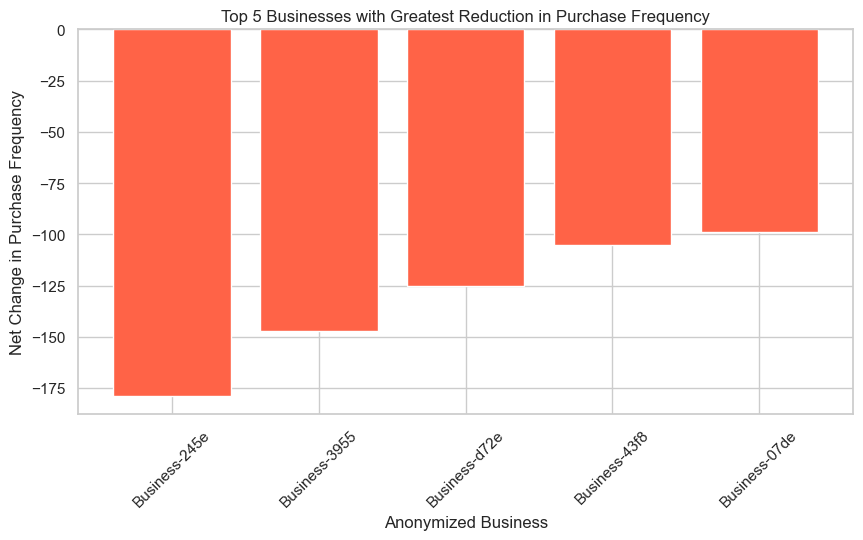

In [127]:
# Plot bar
plt.figure(figsize=(10, 5))
plt.bar(worst_performing_businesses['anonymized business'], worst_performing_businesses['change'], color='tomato')
plt.xlabel('Anonymized Business')
plt.ylabel('Net Change in Purchase Frequency')
plt.title('Top 5 Businesses with Greatest Reduction in Purchase Frequency')
plt.xticks(rotation=45)

# Save the figure
plt.savefig('Images/Top 5 Businesses with Greatest Reduction in Purchase Frequency.png',format='png', dpi=300)

plt.show()

### It is worth noting that our y-axis is negative because these changes have a negative impact overall on our sales.

Businesses identified by this analysis may require further engagement strategies, such as targeted marketing campaigns, special discounts, or personalized communications to understand their needs and challenges better. By addressing these issues, the business can improve retention and potentially reverse negative trends in purchasing behaviour.

**Strategies to Re-engage:**

### 1. Personalized Communications: 
Reach out with personalized emails or messages that acknowledge their reduced purchasing and offer incentives to return.

### 2. Customer Feedback: 
Send surveys to understand their reasons for reduced purchases and address these issues directly.

### 3. Loyalty Programs: 
Enhance or introduce loyalty programs that provide benefits based on purchase frequency or volume, incentivizing repeated business.

## 4.3 Operational Efficiency:Suggest improvements to inventory management or supply chain processes based on trends in product performance and seasonal demand.

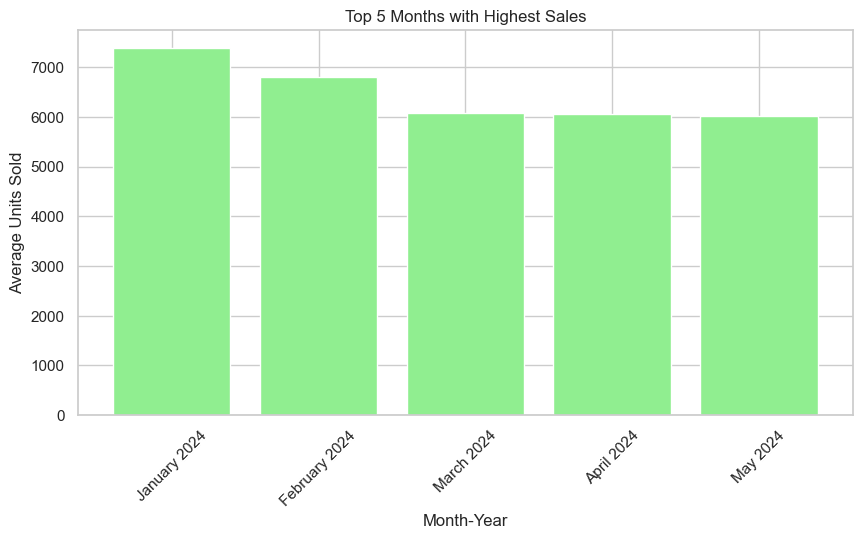

In [130]:
monthly_sales = preprocdata_df.groupby('month-year')['sales'].mean().sort_index()

# Find top 5 months
top_months = monthly_sales.nlargest(5)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(top_months.index, top_months.values, color='lightgreen')
plt.xlabel('Month-Year')
plt.ylabel('Average Units Sold')
plt.title('Top 5 Months with Highest Sales')
plt.xticks(rotation=45)

# Save the figure
plt.savefig('Images/Top 5 Months with Highest Sales.png',format='png', dpi=300)
plt.show()

### By depending on product performance/seasonal demand trend analysis, the following suggestions are made to improve operational efficiency - especially in inventory management/supply chain optimization:

**1. Advanced Demand Forecasting Recommendation:** Use sophisticated demand forecasting methods combining machine learning models. Those models can better model complex patterns and variables impacting sales such as seasonal changes, market trends, promotional impacts and external economic factors.

**Benefits:**

**Precision in Stock Levels:** Accurate forecasting maintains optimal inventory levels - reducing overstock and stockouts.
Cost Efficiency: Holding costs and potential markdowns on excess inventory are reduced.

**Response Time:** Appropriate anticipation of demand spikes and troughs improves responsiveness to market changes.

**Implementation:** 

As shown earlier, use time series forecasting models such as SARIMA or exponential smoothing, adjusted for seasonal variations. 

Add external data like market trends and consumer behaviour analytics to the forecasting models.

**2. Improved Inventory Management using the Just-in-time (JIT) strategy recommendation:** Choose a JIT inventory strategy that matches inventory delivery to production schedules and demand forecasts to reduce inventory holding times.

**Benefits:**

**Reduced Inventory Costs:** The lowest possible inventory level lowers storage and insurance costs.

**Increased Flexibility:** Allows businesses to adjust to customer preferences and demand without excessive stock holding.

**Quality Improvement:** Frequent inventory turnover may eliminate issues with outdated stock.

**Implementation:**

Establish reliable suppliers who can meet your fast and flexible delivery schedules. 

Improve the accuracy of demand forecasts so that the JIT system does not stock out.

**3. Seasonal Stock Optimization Recommendation:** Set inventory levels according to seasonal sales analysis so that stock availability matches predicted seasonal peaks and troughs.

**Benefits:**

**Meet Customer Demand:** Product availability during peak seasons ensures customer satisfaction and sales.

**Efficient Resource Use:** Avoids capitalizing on slow-moving inventory during off-peak seasons.

**Implementation:**

Find specific months or periods with consistently higher sales using sales data. 

Plans for inventory procurement and production ramp-up before the peak periods.

**4. Diversification of suppliers and performance review recommendation:** Diversify suppliers to spread the risk and periodically review supplier performance to ensure that it meets demand requirements, especially during peak periods identified in the sales analysis.

**Benefits:**

**Risk Mitigation:** Reduces risk of supply chain disruptions caused by a single supplier.

**Improved Negotiation Leverage:** Having several suppliers can provide better pricing and terms.

**Quality and Reliability:** Frequent performance reviews ensure suppliers meet quality standards and delivery times.

**Implementation:**
Audit your suppliers regularly for quality and delivery. 
Develop supplier scorecards that rank suppliers on punctuality, quality and responsiveness.

**5. Recommendation for Technology Integration in Supply Chain Management:** Put money into supply chain management software that gives you real-time data across all supply chain touchpoints - from procurement to sales.

**Benefits:**

**Visibility and Control:** Enhances visibility across the supply chain enabling real-time adjustments and decisions.

**Data-Driven Decisions:** Analytics enables better forecasting, inventory management and resource allocation.

**Integration and Automation:** Reduces manual processes & errors.

**Implementation:**

Select the right SCM software based on the business's scale and complexity.

Train staff on new systems to ensure smooth adoption/utilization.

## In conclusion, all these strategies should be adapted to the  business context and built on detailed data analysis, as discussed above. By systematically implementing these recommendations businesses can increase operational efficiency, responsiveness and customer satisfaction.

# 5.0 Saving our Cleaned CaseStudyData to Use on Building a Dashboard

In [133]:
preprocdata_df = preprocdata_df.reset_index()

In [134]:
# Save DataFrame to Excel file
preprocdata_df.to_csv('Data/CleanedCaseStudyData.csv', index=False)